In [ ]:
#library & package. 
#Jalankan ulang jika menambahkan library baru
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json 
import re, string
import tweepy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

basePath="./"

## Part 1 : Data Collection

#### Soal 1
*Instruksi Soal* : Apa kata kunci yang ingin kalian cari di twitter dan kenapa. jelaskan singkat pada sel ini

*Catatan* :

Pada tugas ini, akan diambil data pada twitter dengan menggunakan api yang disediakan oleh twitter. Adapun kata kunci pada pencarian ini adalah "ppkm".
Pencarian ini dilakukan mengingat ada rencana pemerintah mengenai kebijakan ppkm pada akhir tahun baru. Dengan kebijakan itu, saya ingin mengeksplorasi lebih jauh setidaknya dua hal. 
1. Opini umum warganet mengenai ppkm di akhir tahun
2. Bagaimana sentimen warganet


#### Soal 2
*Instruksi Soal* : 

Ambil data pada twitter dengan kata kunci tersebut. ambil sebanyak 300 tweet. masukkan pada datarame dan tampilkan dataframenya


Catatan :
1. Karena saya akan mengakses api tweet publik (yang tidak perlu menyertakan konteks user) maka autentikasi yang digunakan tidak perlu menyertakan access token & access token secret. 
2. Keyword pencarian pada request data adalah ppkm dengan memfilter bahasa yang digunakan dan mengecualikan retweet pada permintaan data
3. Untuk menhindari perubahan analisis dan limitasi jumlah request pada twitter, maka request dilakukan hanya satu kali, kemudian data twitter disimpan di dalam file csv

In [ ]:
# read token from a file
with open(f"{basePath}token.json")as f:
  tokens = json.load(f)

print(tokens.keys())

dict_keys(['bearer_token', 'api_key', 'api_key_secret', 'access_token', 'access_token_secret'])


In [ ]:
auth = tweepy.AppAuthHandler(
    tokens["api_key"], 
    tokens["api_key_secret"]
)

keyword = "ppkm"
api = tweepy.API(auth)
data = []
for tweet in tweepy.Cursor(
    api.search_tweets, 
    q=f'{keyword} -filter:retweets', 
    tweet_mode="extended",
    lang="in"
    ).items(300):
    data.append({
        "id": tweet.id, 
        "tweet": tweet.full_text 
    })

df = pd.DataFrame(data)
display(df)

df.to_csv("data_tweet.csv", index=False)

,id,tweet
0,1467882948875620358,@ddoodoy Gassin sebelum tutup ppkm xixi
1,1467882785138380804,Penanganan pandemi Covid-19 di Indonesia menunjukkan perbaikan signifikan dan terkendali pada tingkat yang rendah meski masih tersisa 12 kabupaten/kota di Jawa-Bali di level 3 PPKM. https://t.co/t6H9b2vyOg
2,1467882601633312769,"@chngeol engga, sy lg gd jadwal pak kan mau ppkm jd gabole ada aktivitas di luar rumah"
3,1467882577428058113,@Aku_Ambivert Kalo taun ini gak tau karna info ppkm masih simpang siur
4,1467882365758296067,"@Getsigege @lidyadwp Hahahaha susah bgt gua weekend\nNtar yuk pas ppkm,gua libur total"
...,...,...
295,1467825760517849092,@aleneversad sirkel ppkm gatuh🙃
296,1467825665210601475,"Kombinasi paling menarik dari minggu ini adalah semua campaign akhir tahun klien deadline di 17 Dec, krn akan ada PPKM, kan… dan anak w PAS 🤪\n\nTerasaaa memabukkaaann! Haha"
297,1467825545664614402,@secretreceipt Hayuu ksna wkkwkw apakah desember akan ppkm lg😭
298,1467825354140446723,-ness libur nataru kan ppkm tuh boleh naik pesawat gaksii??


### Part 2 : Data Cleaning & Preprocessing

#### Soal 3

Instruksi Soal:

- Lakukan Text Preprocessing (lakukan sebaik mungkin). 
- Masukkan pada dataframe kalian dengan nama kolom tweet_clean.
- jangan lupa lakukan pembersihan slang word/bahasa gaul
- Tampilkan dataframe

In [ ]:

pd.set_option('display.max_colwidth', None)

class TweetAnalyzer:
  slangs = {
      "yg": "", 
      "dg": "", 
      "thd": "", 
      "dr": "", 
      "drpd": "",
      "aja": "",
      "jd": "",
      "lg": "",
      "tak": "tidak",
      "tdk": "tidak",
      "gak": "tidak", 
      "engga": "tidak",
      "enggak": "tidak", 
      "ga": "tidak", 
      "g": "tidak", 
      "blm": "belum",
      "tp": "tapi", 
      "belom": "belum", 
      "jgn": "jangan", 
      "bkn": "bukan"
    }  

  def __init__(self, df):
    self.df = df.copy()
    self.blackList = stopwords.words('indonesian')
    self.cleanTweet()

  def cleanTweet(self):
    # 1. case folding
    # 2. remove / replace slangs
      # merubah / mengganti kata slang umum yang biasa 
      # digunakan dalam percakapan
      # untuk kata hubung, saya putuskan untuk menghapusnya, sedangkan untuk 
      # kata lain saya ganti dengan kata formal bahasa indonesia
    # 3. removeStopWords
    # 4. stemming

    self.df["tweet_clean"] = self.df["tweet"].apply(self.caseFolding)
    self.replaceSlang(slangs=TweetAnalyzer.slangs)
    self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.removeStopWords)   
    # self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.stemming) 

  def showHead(
    self,
    columns=["tweet", "id", "tweet_clean"],
    n=5
  ):
    display(self.df[columns].head(n)) 

  def caseFolding(self, text):
    # 1. convert to lower case
    # 2. replace digit & link with a whitespace 
    # 3. remove &amp \n or \t
    # 4. remove white space
    # 5. remove punctuation
    text = text.lower()
    text = re.sub(r"\d+|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    text = text.strip()
    text = text.translate(text.maketrans("", "", string.punctuation))
    return text
  
  def replaceSlang(self, slangs):
    self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.replaceText, slangs=slangs)

  def replaceText(self, text, slangs):
    splittedText = word_tokenize(text)
    splittedText = [word if word not in slangs.keys() else (word if slangs[word]!="" else slangs[word]) for word in splittedText]
    text = " ".join(splittedText)
    text = re.sub(' +', ' ', text)
    return text

  def removeStopWords(self, text):
    text = word_tokenize(text)
    cleanText = [word for word in text if word not in self.blackList]
    return " ".join(cleanText) 

  def stemming(self, text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

  def showFqCharPerTweet(self):
    self.df["tweet_clean"].str.len().hist(bins=20)
    plt.title("Distribusi Frekuensi jumlah huruf pada suatu data")
    plt.show()

  def showNumWordPerTweet(self):
    self.df["tweet_clean"].str.split().map(lambda x: len(x)).hist(bins=20)
    plt.title("Distribusi Frekuensi jumlah kata pada suatu data")
    plt.show()
  
  def getAvgWord(self, x):
      x = x.split()
      x = map(lambda x: len(x), x)
      return(np.average(list(x)))

  def showAvgWordPerTweet(self):
    self.df["tweet_clean"].apply(self.getAvgWord).hist(bins=20)
    plt.title("Distribusi Frekuensi panjang kata rata-rata pada suatu data")
    plt.show()

  def genAllWord(self): 
    self.df["tokenize"] = self.df["tweet_clean"].apply(lambda x: x.split(" ")) 
    self.allWord = [word for tweet in self.df["tokenize"] for word in tweet]
    
  def freqWordDist(self, nWord=20):
    self.genAllWord()
    print("Distribusi Frekuensi kata yang sering keluar")
    fqdist = FreqDist(self.allWord)
    fqdist.plot(nWord, cumulative=False)

  def nGramsDist(self, n=2, nWord=20):
    self.genAllWord()
    result = pd.Series(ngrams(self.allWord, n)).value_counts()[:nWord]
    print(f"#Distribusi N-gram (n={n})")
    print(result)
  
  def genWordCloud(self):
    self.genAllWord()
    wordcloud = WordCloud(
      random_state=1,
      background_color='black',
      colormap='Pastel1', 
      max_words=100,
      collocations=False  
    ).generate(" ".join(self.allWord))
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis("off")

# Membaca data tweet pada file & membuat object TweetAnalyzer
df = pd.read_csv("data_tweet.csv")
analyze = TweetAnalyzer(df)

# Menampilkan hasil pembersihan
analyze.df

,id,tweet,tweet_clean
0,1467882948875620358,@ddoodoy Gassin sebelum tutup ppkm xixi,gassin tutup ppkm xixi
1,1467882785138380804,Penanganan pandemi Covid-19 di Indonesia menunjukkan perbaikan signifikan dan terkendali pada tingkat yang rendah meski masih tersisa 12 kabupaten/kota di Jawa-Bali di level 3 PPKM. https://t.co/t6H9b2vyOg,penanganan pandemi covid indonesia perbaikan signifikan terkendali tingkat rendah tersisa kabupaten kota jawa bali level ppkm
2,1467882601633312769,"@chngeol engga, sy lg gd jadwal pak kan mau ppkm jd gabole ada aktivitas di luar rumah",engga sy gd jadwal ppkm gabole aktivitas rumah
3,1467882577428058113,@Aku_Ambivert Kalo taun ini gak tau karna info ppkm masih simpang siur,ambivert kalo taun gak tau karna info ppkm simpang siur
4,1467882365758296067,"@Getsigege @lidyadwp Hahahaha susah bgt gua weekend\nNtar yuk pas ppkm,gua libur total",hahahaha susah bgt gua weekend ntar yuk pas ppkm gua libur total
...,...,...,...
295,1467825760517849092,@aleneversad sirkel ppkm gatuh🙃,sirkel ppkm gatuh
296,1467825665210601475,"Kombinasi paling menarik dari minggu ini adalah semua campaign akhir tahun klien deadline di 17 Dec, krn akan ada PPKM, kan… dan anak w PAS 🤪\n\nTerasaaa memabukkaaann! Haha",kombinasi menarik minggu campaign klien deadline dec krn ppkm anak w pas terasaaa memabukkaaann haha
297,1467825545664614402,@secretreceipt Hayuu ksna wkkwkw apakah desember akan ppkm lg😭,hayuu ksna wkkwkw desember ppkm
298,1467825354140446723,-ness libur nataru kan ppkm tuh boleh naik pesawat gaksii??,ness libur nataru ppkm tuh pesawat gaksii


### Part 3 : Text Analysis

*Instruksi Soal*

1. lakukan semua Text Analysis, seperti word_frequency, mean_word_length, dsb. tampilkan plot dari setiap analysis
3. dengan melihat word_frequency coba perbaiki pembersihan slang word pada tweet_clean
4. tampilkan dataframe kalian


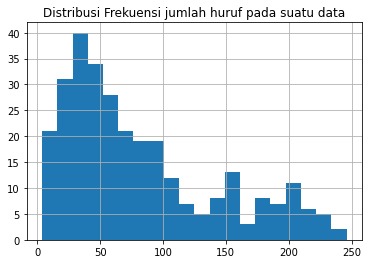

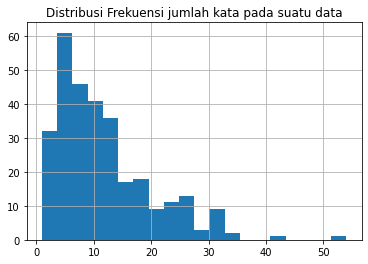

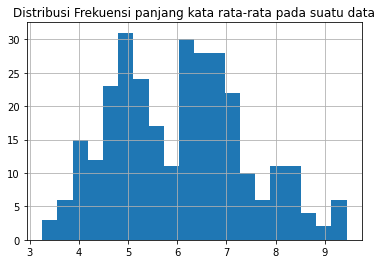

Distribusi Frekuensi kata yang sering keluar


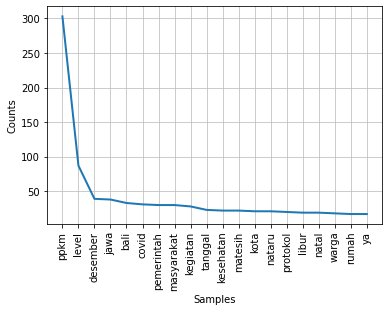

#Distribusi N-gram (n=2)
(ppkm, level)                68
(jawa, bali)                 33
(ppkm, jawa)                 27
(protokol, kesehatan)        20
(mematuhi, protokol)         11
(warga, masyarakat)          11
(kegiatan, masyarakat)       11
(pembatasan, kegiatan)       11
(masyarakat, mematuhi)       11
(koramil, matesih)           11
(matesih, melaksanakan)      11
(masyarakat, ppkm)           10
(diperpanjang, desember)     10
(membagikan, masker)          9
(beraktifitas, didalam)       8
(perpanjang, ppkm)            8
(pemerintah, perpanjang)      8
(masker, warga)               8
(kesehatan, beraktifitas)     8
(didalam, diluar)             8
dtype: int64


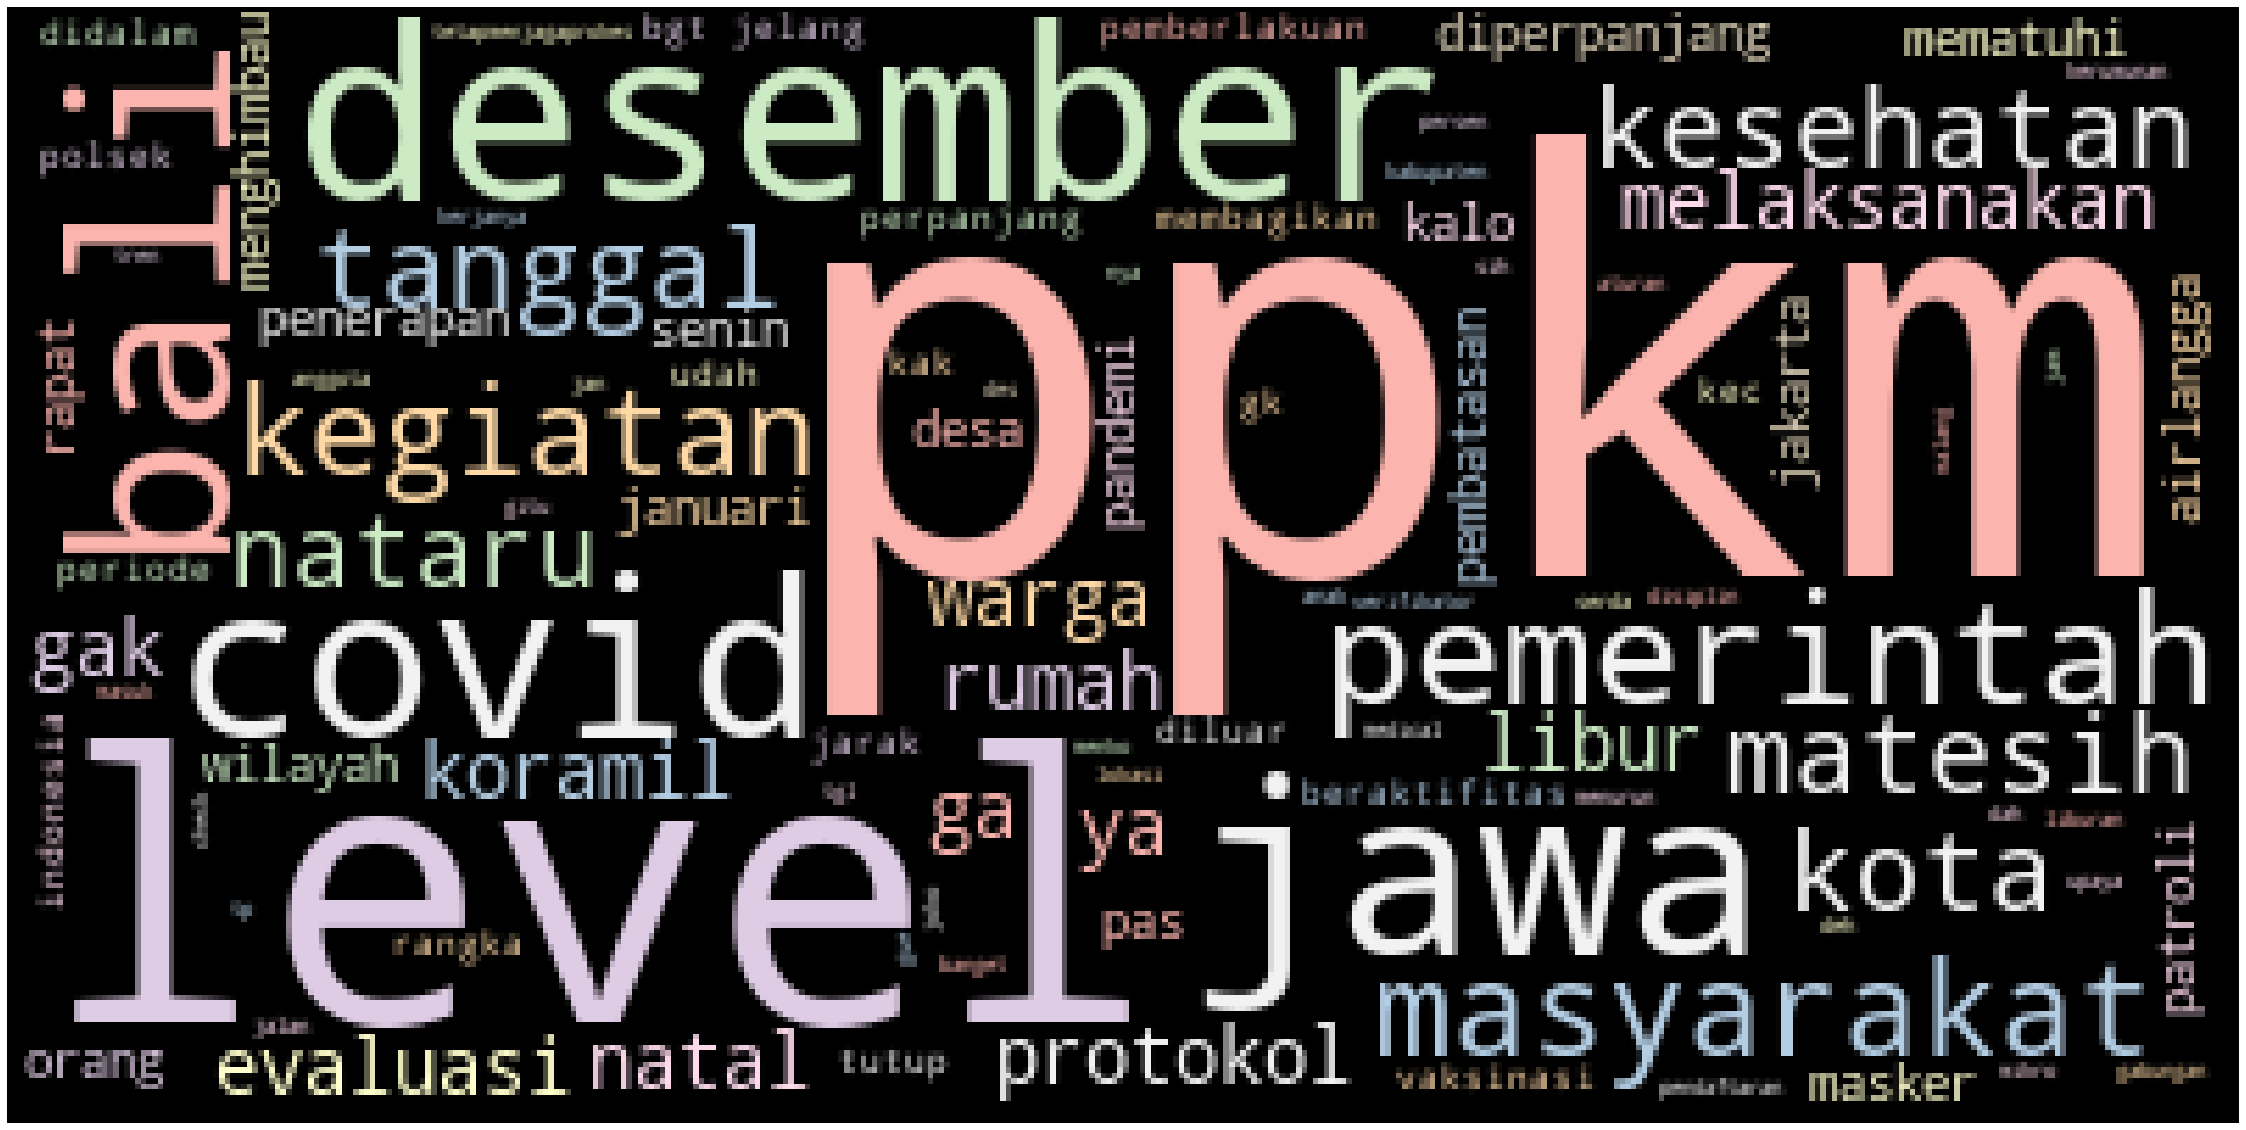

In [ ]:
# 1. Menampilkan teks analisis

# Distribusi Frekuensi karakter per tweet
analyze.showFqCharPerTweet()
# Distribusi panjang kata per tweet
analyze.showNumWordPerTweet()
# Distribusi panjang rata-rata kata per tweet
analyze.showAvgWordPerTweet()
# Distribusi Kata
analyze.freqWordDist()
# Word Cloud
analyze.genWordCloud()
# Distribusi N-Gram
analyze.nGramsDist()


*Catatan :*

Berdasarkan frekuensi kata, word cloud dan distribusi n-gram terdapat beberapa kata yang nampaknya perlu dihilangkan. antara lain :
- kata slang atau stop words seperti : ya, kalo, udah, gk, gue, bgt, kalo, dah, tgl. Untuk kata penghubung, akan dihilangkan sedangkan kata yang memiliki peran pada sentimen, dikonversi menjadi bahasa indonesia yang baik.

<!-- - Muncul kata "matesih" pada retweet, setelah diperiksa, ada tweet yang berulang (bukan berasal dari retweet, karena pada saat request telah difilter terlebih dahulu). Oleh karena itu, baris tersebut akan dihilangkan dari data, dan disisakan hanya satu tweet saja. -->

Distribusi Frekuensi kata yang sering keluar


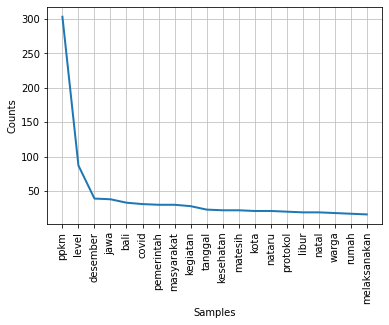

#Distribusi N-gram (n=2)
(ppkm, level)               68
(jawa, bali)                33
(ppkm, jawa)                27
(protokol, kesehatan)       20
(masyarakat, mematuhi)      11
(pembatasan, kegiatan)      11
(kegiatan, masyarakat)      11
(koramil, matesih)          11
(matesih, melaksanakan)     11
(warga, masyarakat)         11
(mematuhi, protokol)        11
(diperpanjang, desember)    10
(masyarakat, ppkm)          10
(membagikan, masker)         9
(masker, warga)              8
(perpanjang, ppkm)           8
(pemerintah, perpanjang)     8
(evaluasi, ppkm)             8
(didalam, diluar)            8
(bali, diperpanjang)         8
dtype: int64


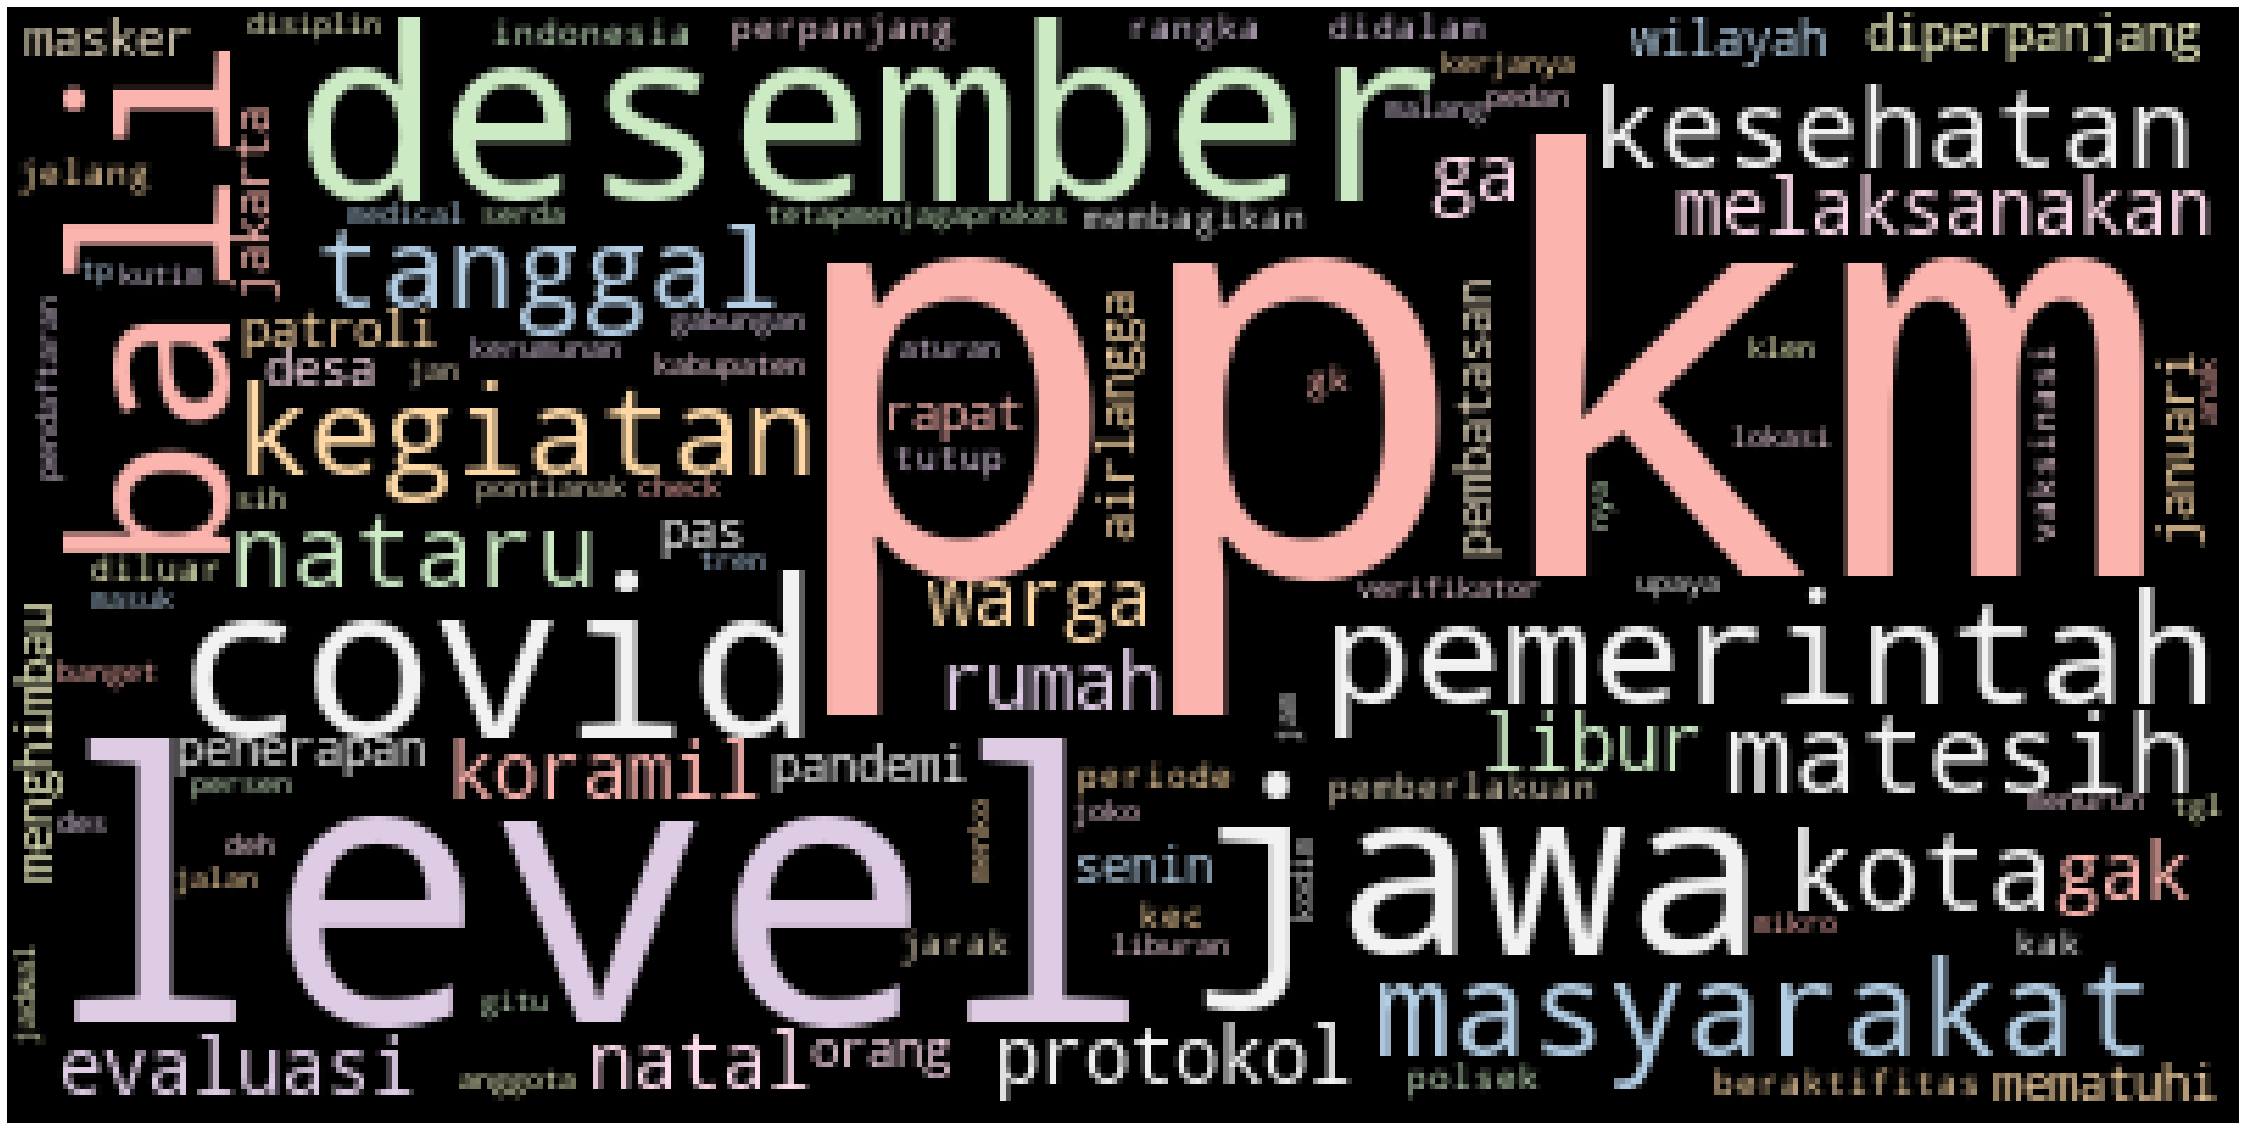

In [ ]:
# remove / replace slang
slangs = {
    "ya": "", 
    "kalo": "", 
    "udah": "",
    "gk": "tidak", 
    "gue": "", 
    "bgt": "", # saya kurang yakin apakah menunjukkan banget atau begitu 
    "dah": "", 
    "tgl": "tanggal"
}
analyze.replaceSlang(slangs=slangs)

# Distribusi Kata
analyze.freqWordDist()
# Word Cloud
analyze.genWordCloud()
# Distribusi N-Gram
analyze.nGramsDist()


Setelah dilakukan pembersihan beberapa kata, kita mendapatkan beberapa kata-kata baru yang masuk ke dalam 20 kata yang paling banyak digunakan. baik pada word count atau distribusi n-gram bisa kita peroleh warganet membicarakan mengenai kebijakan pemerintah berkaitan ppkm khususnya yang ditetapkan pada jawa-bali pada libur natal dan awal tahun baru (nataru). Pada perbincangan itu muncul ajakan kepada masyarakat untuk mematuhi protokol kesehatan.  

### Part 3 : Sentiment Analysis

Instruksi Soal :

- Lakukan Sentiment Analysis 
- masukkan hasilnya pada dataframe dengan nama kolom "sentiment"



In [ ]:
def readList(fileName):
    tFile = open(fileName, "r")
    result = tFile.readlines()    
    return [word.strip() for word in result]    

negations = ['tidak','lawan','anti', 'jangan', 'bukan', 'sulit', 'tak']
positiveWord = readList(f"{basePath}/kata_positif.txt")
negativeWord = readList(f"{basePath}/kata_negatif.txt")

sentimentValues = []

def getSentiment(text):
    splittedText = text.split()
    numPositive = 0
    numNegative = 0

    for idx, word in enumerate(splittedText):
        if word in positiveWord:
            if (splittedText[idx-1] in negations):
                numNegative+=1
                # print(splittedText[idx-1], word, ": negative")
            else :
                numPositive+=1
                # print(word, ": positive")
        
        elif word in negativeWord:
            if (splittedText[idx-1] in negations):
                numPositive+=1
                # print(splittedText[idx-1], word, ": positive")
            else :
                numNegative+=1
                # print(word, ": negative")

    # print("positive", numPositive)
    # print("negative", numNegative)
    value = numPositive-numNegative
    # print(value)
    sentimentValues.append(value)
    return "positive" if value>=0 else "negative" 

analyze.df["sentiment"] = analyze.df["tweet_clean"].apply(getSentiment)
analyze.df["sValue"] = sentimentValues
analyze.df[["tweet", "tweet_clean","sValue", "sentiment"]]


,tweet,tweet_clean,sValue,sentiment
0,@ddoodoy Gassin sebelum tutup ppkm xixi,gassin tutup ppkm xixi,-1,negative
1,Penanganan pandemi Covid-19 di Indonesia menunjukkan perbaikan signifikan dan terkendali pada tingkat yang rendah meski masih tersisa 12 kabupaten/kota di Jawa-Bali di level 3 PPKM. https://t.co/t6H9b2vyOg,penanganan pandemi covid indonesia perbaikan signifikan terkendali tingkat rendah tersisa kabupaten kota jawa bali level ppkm,0,positive
2,"@chngeol engga, sy lg gd jadwal pak kan mau ppkm jd gabole ada aktivitas di luar rumah",engga sy gd jadwal ppkm gabole aktivitas rumah,0,positive
3,@Aku_Ambivert Kalo taun ini gak tau karna info ppkm masih simpang siur,ambivert taun gak tau karna info ppkm simpang siur,0,positive
4,"@Getsigege @lidyadwp Hahahaha susah bgt gua weekend\nNtar yuk pas ppkm,gua libur total",hahahaha susah gua weekend ntar yuk pas ppkm gua libur total,-1,negative
...,...,...,...,...
295,@aleneversad sirkel ppkm gatuh🙃,sirkel ppkm gatuh,0,positive
296,"Kombinasi paling menarik dari minggu ini adalah semua campaign akhir tahun klien deadline di 17 Dec, krn akan ada PPKM, kan… dan anak w PAS 🤪\n\nTerasaaa memabukkaaann! Haha",kombinasi menarik minggu campaign klien deadline dec krn ppkm anak w pas terasaaa memabukkaaann haha,1,positive
297,@secretreceipt Hayuu ksna wkkwkw apakah desember akan ppkm lg😭,hayuu ksna wkkwkw desember ppkm,0,positive
298,-ness libur nataru kan ppkm tuh boleh naik pesawat gaksii??,ness libur nataru ppkm tuh pesawat gaksii,0,positive


Nilai rata-rata: 0.07
Standar deviasi: 0.9721625378505386


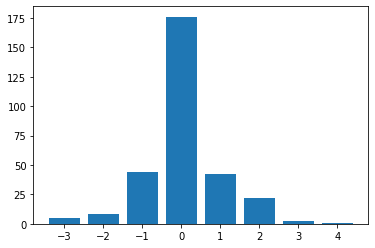

In [ ]:
#lakukan analisis dan tarik kesimpulan dari Text analysis dan Sentiment Analysis
#masukkan analisis kalian pada sel berikut.

print (f"Nilai rata-rata: {np.mean(sentimentValues)}")
print (f"Standar deviasi: {np.std(sentimentValues)}")

labels, counts = np.unique(sentimentValues, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

*Analisis*

Berikut adalah analisis terhadap data yang diperoleh dari twitter yang  diambil pada tanggal 6 Desember 2021.  

- Dengan nilai rata-rata sentimen 0.07, warganet cenderung memiliki sentimen positif atas kebijakan ppkm di akhir tahun. 
- Standar deviasi nilai sentiment adalah 0.98, hal ini menunjukkan secara umum data tidak memiliki penyimpangan yang jauh dari nilai rata-rata
- Sebaran sentimen, terdistribusi normal dengan mayoritas nilai sentimennya cenderung memiliki nilai 0. 
- Dengan ini, pemerintah memiliki dukungan dari sebagian warganet melanjutkan penetapan PPKM di akhir tahun.
- Perlu dilakukan kembali pengambilan data dengan jumlah yang cukup besar untuk memastikan gambaran umum sentimen warganet mengenai kebijakan ppkm.